In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib as mpl
from datetime import datetime, date, time, timedelta

In [2]:
# import data from scores table
# import data from signal table
#
#
#
#
#
#
#

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

dbname = 'urx'
username = 'noahburbank'

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

features = pd.read_csv('features.csv')
scores = pd.read_csv('aggregated_scores.csv')

In [3]:
# import worker data 
# connect:
con = None
con = psycopg2.connect(database = dbname, user = username)


# make sure to choose the correct table for which experiment you're looking at: worker_table_exp#
# query:
sql_query = """
SELECT * FROM worker_table_exp2;
"""
worker_table = pd.read_sql_query(sql_query,con)

print worker_table.columns

Index([u'index', u'_worker_id', u'too_many_jobs', u'too_little_variance',
       u'unreasonable_mean', u'suspicious_timestamps', u'_trust',
       u'agg_score'],
      dtype='object')


In [5]:
# make sure that you have the appropriate experiment for the worker table that you're working with
#raw_df = pd.read_csv('experiment1_data.csv')
raw_df = pd.read_csv('experiment2_data.csv')

In [6]:
# sort a dictionary by country before putting into the dataframe
def sort_by_country(unsorted_dict):
    sorted_list = []
    for country in country_df['_country']:
        sorted_list.append(unsorted_dict[country])
    return sorted_list

In [7]:
# masterlist of country information
country_list = []
country_scores_dict = dict()
jobs_count = dict()
mean_trust = dict()
median_trust = dict()

for entry in raw_df.groupby('_country'):
    country_list.append(entry[0])
    jobs_count[entry[0]] = len(entry[1]['please_make_your_relevancy_judgment'] )
    mean_trust[entry[0]] = entry[1]['_trust'].mean()
    median_trust[entry[0]] = entry[1]['_trust'].median()

jobs_list = []
mean_trust_list = []
median_trust_list = []

# create df and put data into it
country_df = pd.DataFrame()
country_df['_country'] = country_list


for country in country_df['_country']:
    jobs_list.append(jobs_count[country])
    mean_trust_list.append(mean_trust[country])
    median_trust_list.append(median_trust[country])

In [8]:
# consolidate into a dataframe

country_df = pd.DataFrame()
country_df['_country'] = country_list
country_df['jobs_count'] = jobs_list
country_df['mean_trust'] = mean_trust_list
country_df['median_trust'] = median_trust_list

In [9]:
# dict of country and ids
country_dict = dict()
worker_job_count = dict()
trust_dict = dict()

for line in raw_df.groupby('_worker_id'):
    country_key = line[1]['_country'].keys()[1]
    country_dict[line[0]] = line[1]['_country'][country_key] 
    worker_job_count[line[0]] = line[1]['please_make_your_relevancy_judgment'].count()
    trust_key = line[1]['_trust'].keys()[1]
    trust_dict[line[0]] = line[1]['_trust'][trust_key]

In [10]:
# basic information about workers and countries 
worker_df = pd.DataFrame()
worker_df['_worker_id'] = country_dict.keys()
worker_df['_country'] = country_dict.values()
worker_df['job_count'] = worker_job_count.values()
worker_df['_trust'] = trust_dict.values()

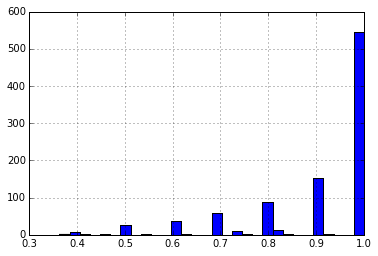

In [11]:
## detect majority judgments (and how much of a majority)

modes = []
mode_counts = []
judgment_counts = []
plurality_percentages = []
plurality_judgment = dict()

for line in raw_df.groupby('_unit_id'):
    unit_id = line[0]
    judgments = line[1]['please_make_your_relevancy_judgment']
    mode = judgments.mode()
    mode = int(mode[0])
    modes.append(mode)
    mode_count = 0
    for judgment in judgments:
        if judgment == mode:
            mode_count += 1
    mode_counts.append(mode_count)
    judgment_count = len(judgments)
    judgment_counts.append(judgment_count)
    plurality_percentage = (mode_count +0.0)/judgment_count
    plurality_percentages.append(plurality_percentage)
    plurality_judgment[line[0]] = mode, plurality_percentage
    

pd.Series(data= plurality_percentages).hist(bins=30)

In [12]:
# detect minority judgments by worker
worker_is_in_the_minority = dict()

for line in raw_df.iterrows():
    worker_id = line[1]['_worker_id']
    worker_judgment = line[1]['please_make_your_relevancy_judgment']
    unit_id = line[1]['_unit_id']
    
    majority_judgment = plurality_judgment[unit_id][0]
    # in the first pass i don't take into account how much of a majority/plurality it is
    
    is_minority =  (worker_judgment != majority_judgment)
    if is_minority == 1:
        if worker_id not in worker_is_in_the_minority.keys():
            worker_is_in_the_minority[worker_id] = 1
        else:
            worker_is_in_the_minority[worker_id] += 1        

# fill out for the three remaining majority voters
for worker in worker_df['_worker_id']:
    if worker not in worker_is_in_the_minority.keys():
        worker_is_in_the_minority[worker] = 0

is_minority_ordered = []
# reorder for the order that the worker df is in 
for worker in worker_df['_worker_id']:
    is_minority_ordered.append(worker_is_in_the_minority[worker])
    
# add to the data frame
worker_df['minority_judgments'] = is_minority_ordered

# add a column with the minority precentage as a 
worker_df['minority_percentage'] = worker_df['minority_judgments'] / worker_df['job_count']

In [13]:
# bring this up to the country level, aggregating there, and not subaggregating by worker first 
country_minority_dict = dict()

for country in worker_df.groupby('_country'):
    total_judgments = country[1]['job_count'].sum()
    total_minority_judgments = country[1]['minority_judgments'].sum()
    total_minority_percentage = (total_minority_judgments + 0.0) / total_judgments
    country_minority_dict[country[0]] = total_minority_percentage

## bring this up to the country level, but aggregate on the worker first 
country_minority_by_worker_dict = dict()

for country in worker_df.groupby('_country'):
    minority_average = country[1]['minority_percentage'].mean()
    country_minority_by_worker_dict[country[0]] = minority_average

# these are not meaningfully different, so let's just take the country one, without the worker sub-aggregation

In [14]:
# can you sort through people by the minority judgments?

ordered_country_minority_list = []
for country in country_df['_country']:
    ordered_country_minority_list.append(country_minority_dict[country])

country_df['percent_minority_judgments'] = ordered_country_minority_list

,_country,jobs_count,mean_trust,median_trust,percent_minority_judgments,is_bad
0,ARG,373,0.972432,0.9783,0.093834,0
1,BGD,46,1.000000,1.0000,0.065217,0
2,BIH,8,0.909100,0.9091,0.250000,1
3,COL,247,0.948700,0.9487,0.068826,0
4,EST,28,1.000000,1.0000,0.035714,0
5,GTM,74,0.947400,0.9474,0.081081,0
6,HRV,167,0.933300,0.9333,0.077844,0
7,IDN,1556,0.931067,0.9286,0.162596,0
8,IND,1231,0.936093,0.9149,0.082047,0
9,IRL,109,1.000000,1.0000,0.073394,0


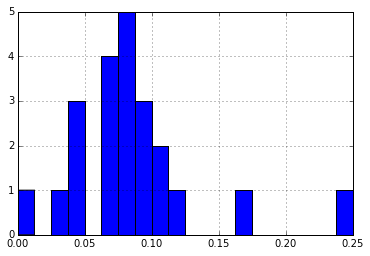

In [15]:
# see the corresponde of low trust and minority judgments 
country_df['percent_minority_judgments'].hist(bins = 20)

minority_judgments = country_df['percent_minority_judgments']

## remove the contradictory countries: 

mu = np.mean(minority_judgments)
z = 1.96
other_part = (mu)*(1-mu)/len(minority_judgments)
other_part = other_part ** .5
low_ci_val = mu - z*other_part
high_ci_val = mu + z*other_part

# th is totally wrong, but let's just use the high ci for a normal distribution for 95% confidence and see where that goes


bad_countries = []
for country in country_df['_country']:
    is_bad = float(country_df['percent_minority_judgments'][country_df['_country'] == country])  > high_ci_val
    bad_countries.append(int(is_bad))
country_df['is_bad'] = bad_countries
country_df

In [16]:
# consolidate countries into good and bad based on how often people are contradictory to the plurality/majority
good_countries = []
for line in raw_df.iterrows():
    country_val = int(line[1]['_country'] in set(country_df[country_df['is_bad'] != 1]['_country']))
    good_countries.append(country_val)

In [17]:
# make the big changes 
temp_df = raw_df
temp_df['good_country'] = good_countries
good_countries_only = temp_df[raw_df['good_country'] == 1]


# output the conclusiosn of what's going on here 
print "there are " + str(sum(country_df['is_bad'])) + " bad countries" 
print "with over " + str(round(high_ci_val * 100,2)) + " percent judgments going against the majority/plurality"

missed_judgments = len(raw_df) - len(good_countries_only)
total_judgments = len(raw_df)
percent_lost = float(missed_judgments) / total_judgments

print 
print "eliminating them eliminates " + str(missed_judgments) + ' out of ' + str(total_judgments) + " judgments"
print "which is " + str(round(percent_lost  * 100, 2)) + '% of the judgments '
print 
print "there are now only " + str(len(good_countries_only)) + " judgments in the dataset"

fewest_judgments = good_countries_only.groupby('_unit_id')['please_make_your_relevancy_judgment'].count().min()

print 
print 'the worst covered unit pair contains only ' + str(fewest_judgments) + " judgments"

there are 1 bad countries
with over 20.2 percent judgments going against the majority/plurality

eliminating them eliminates 8 out of 9633 judgments
which is 0.08% of the judgments 

there are now only 9625 judgments in the dataset

the worst covered unit pair contains only 9 judgments


In [44]:
# output to the worker table in the db
#
#
#
#
#
#
#
#
# need libraries for conneting with databse 
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

# create sql engine
dbname = 'urx'
username = 'noahburbank'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [18]:
# make sure to adjust the database name to reflect your current experiment 
# upload to the database

country_df.to_sql('country_table_exp2', engine, if_exists = 'replace')

In [46]:
# still not sure why this is here...
#good_countries_only.to_sql('good_country_table', engine, if_exists = 'replace')